In [1]:
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier

In [2]:
from cpa_utils import *

In [3]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples_full_filter\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples_full_filter\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"

In [4]:
seeds_total, traces_total, real_keys = load_data(traces_path, key_path)

In [5]:
EARLIEST_ROUND = 0

In [6]:
KEY_ALPHABET = list(range(16))

In [8]:
#traces_train, traces_test, seeds_train, seeds_test = (a[np.newaxis, :] for a in train_test_split(traces_varying[0], seeds_varying[0], test_size=5000, random_state=0))

In [6]:
#traces_train, traces_test = traces_train[:, :, 11:], traces_test[:, :, 11:]
#traces_train.shape, traces_test.shape

## Profiling stage

### Choosing one point per clock cycle

Arduino Due: 84 MHz
Sampling rate: 2.5 GHz

In [6]:
SAMPLES_PER_CYCLE = int(2500 / 84)
SAMPLES_PER_CYCLE

29

29 points per cycle

#### SOST

In [9]:
def signal_strength_and_template_means_per_index(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, int(SAMPLES_PER_CYCLE * np.ceil(traces.shape[1] / SAMPLES_PER_CYCLE))), dtype=np.float32)
    all_m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float32)
    g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[0]), dtype=bool)

    for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
        for block_idx in range(BLOCK_WIDTH_B4):
            card_g = np.zeros((len(KEY_ALPHABET), 1), dtype=np.int32)
            m = all_m[round_idx][block_idx]
            v = np.zeros((len(KEY_ALPHABET), traces.shape[1]), dtype=np.float64)

            for seed, (i, trace) in zip(seeds, enumerate(traces)):
                indices, whitening = chacha_random_b4(seed)
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                g[round_idx][block_idx][real_k][i] = True
                card_g[real_k][0] += 1
                m[real_k] += trace
                v[real_k] += np.square(trace.astype(np.float64))

            m /= card_g
            v = (v - card_g * m * m) / (card_g - 1)

            for i in range(len(KEY_ALPHABET)):
                for j in range(i + 1, len(KEY_ALPHABET)):
                    num = m[i] - m[j]
                    den = np.sqrt(v[i] / card_g[i] + v[j] / card_g[j])
                    f[round_idx][block_idx][:traces.shape[1]] += np.square(num / den)
    
    return f, all_m, g

#### Correlation

In [10]:
def correlation_signal_strength_and_template_means_per_index(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, int(SAMPLES_PER_CYCLE * np.ceil(traces.shape[1] / SAMPLES_PER_CYCLE))), dtype=np.float32)
    all_m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float32)
    g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4,  len(KEY_ALPHABET), traces.shape[0]), dtype=bool)

    for round_idx in range(12, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
        for block_idx in range(BLOCK_WIDTH_B4):
            card_g = np.zeros((len(KEY_ALPHABET), 1), dtype=np.int32)
            m = all_m[round_idx][block_idx]
            hypotheses = np.zeros(traces.shape[0])

            for seed, (i, trace) in zip(seeds, enumerate(traces)):
                indices, whitening = chacha_random_b4(seed)
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                g[round_idx][block_idx][real_k][i] = True
                card_g[real_k][0] += 1
                m[real_k] += trace
                if block_idx % 2 == 0 and block_idx != 6:
                    hypotheses[i] = HW[s_boxes_b4[block_idx][real_k]]
                elif block_idx % 2 != 0:
                    hypotheses[i] = HW[s_boxes_b4[block_idx][(real_k + key[indices[keyround_index - 1]] + whitening[keyround_index - 1]) % 16]]

            m /= card_g

            f[round_idx][block_idx][:traces.shape[1]] = corr_coef_vectorized(hypotheses, traces)
    return f, all_m, g

In [11]:
f, template_means, g = signal_strength_and_template_means_per_index(seeds_train[0], real_keys[0], traces_train[0])

In [82]:
f, template_means, g = correlation_signal_strength_and_template_means_per_index(seeds_train[0], real_keys[0], traces_train[0])

c:\Users\Kudelski\Documents\Pierugo-PDM-2024\side_channel_attack\cpa_utils.py:58: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


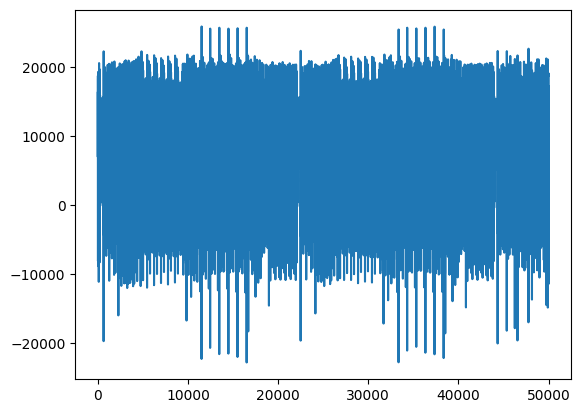

In [11]:
plt.plot(traces_train[0][1000])

In [167]:
interesting_points_per_index[13, 2]

array([24679., 28678., 24555., 28550., 24510., 31853., 28638., 24711.,
       28351., 29070.])

(24600.0, 29000.0)

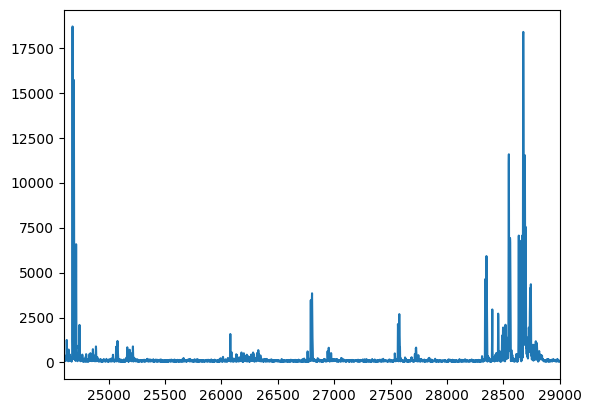

In [155]:
plt.plot(f[13, 2])
plt.xlim([24600, 29000])

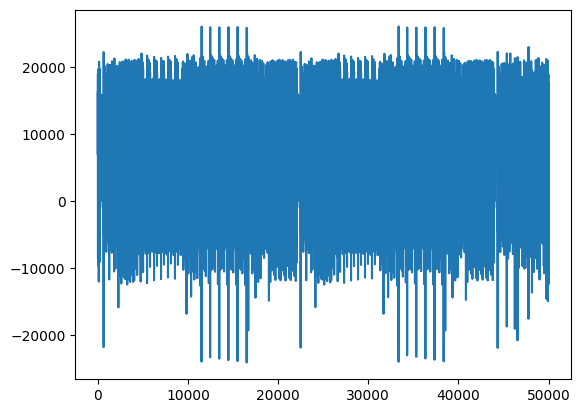

In [122]:
plt.plot(template_means[13, 2, 1])

In [165]:
#interesting_points_per_index = np.array([i + np.argmax(f[..., i:i+SAMPLES_PER_CYCLE], axis=-1) for i in range(0, f.shape[-1], SAMPLES_PER_CYCLE)]).transpose(1, 2, 0)
#f_one_per_cycle = f[np.arange(f.shape[0])[:, np.newaxis, np.newaxis], np.arange(f.shape[1])[:, np.newaxis], interesting_points_per_index]
#interesting_points_in_reduced = np.apply_along_axis(np.argpartition, axis=2, arr=f_one_per_cycle, kth=-5)[:, :, -5:]
#interesting_points_per_index = np.sort(interesting_points_per_index[np.arange(f.shape[0])[:, np.newaxis, np.newaxis], np.arange(f.shape[1])[:, np.newaxis], interesting_points_in_reduced], axis=2)

#interesting_points_per_index = np.apply_along_axis(np.argpartition, axis=2, arr=f[:, :, :traces_train.shape[2]], kth=-10)[:, :, -10:]
#most_interesting_point = np.argmax(f[:, :, :traces_train.shape[2]], axis=2)
#interesting_points_per_index = np.stack([most_interesting_point + s * SAMPLES_PER_CYCLE for s in range(-1, 2)], axis=2)


In [27]:
interesting_points_per_index = np.zeros((f.shape[0], f.shape[1], 10), dtype=int)
sorted_strengths = np.argsort(f[:, :, :traces_train.shape[2]], axis=2)[:, :, ::-1]

for round_idx in range(sorted_strengths.shape[0]):
    for block_idx in range(sorted_strengths.shape[1]):
        largest_indices = []
        for ind in sorted_strengths[round_idx, block_idx]:
            if len(largest_indices) < interesting_points_per_index.shape[2]:
                if all(abs(i - ind) >= SAMPLES_PER_CYCLE for i in largest_indices):
                    largest_indices.append(ind)
            else:
                break
        interesting_points_per_index[round_idx, block_idx] = np.array(largest_indices)


In [28]:
traces_reduced = traces_train[0][:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_reduced.shape

(14, 7, 124499, 10)

### Multivariate Gaussian parameters

In [29]:
template_means_reduced = template_means[np.arange(template_means.shape[0])[:, np.newaxis, np.newaxis, np.newaxis], np.arange(template_means.shape[1])[:, np.newaxis, np.newaxis], np.arange(template_means.shape[2])[:, np.newaxis], np.repeat(interesting_points_per_index[:, :, np.newaxis, :], 16, axis=2)]
template_means_reduced.shape

(14, 7, 16, 10)

In [30]:
template_means_reduced[13, 2, 15]

array([ 4931.5957, 10003.278 ,  9771.015 ,  6146.0586,  7164.736 ,
       15635.32  ,  5921.5845,  6622.381 ,  9714.859 ,  4538.6064],
      dtype=float32)

In [31]:
template_means[13, 2, 15, [24679, 24680, 24689, 24690, 24691, 28676, 28677, 28678, 28679, 28680]]

array([ 4931.5957,  4682.3306,  9182.5   ,  8496.582 ,  8094.0737,
       12106.637 , 11155.582 , 10003.278 ,  9041.981 ,  8145.944 ],
      dtype=float32)

In [37]:
covariance_matrices = np.zeros(g.shape[:3] + (traces_reduced.shape[3],) * 2)
for i in range(g.shape[0]):
    for j in range(g.shape[1]):
        for k in range(g.shape[2]):
            covariance_matrices[i, j, k] = np.nan_to_num(np.cov(traces_reduced[i, j, g[i, j, k]], rowvar=False), nan=0.0)
covariance_matrices.shape

c:\Users\Kudelski\Documents\Pierugo-PDM-2024\side_channel_attack\.venv\Lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\side_channel_attack\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\Kudelski\AppData\Local\Temp\ipykernel_4052\2809304104.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance_matrices[i, j, k] = np.nan_to_num(np.cov(traces_reduced[i, j, g[i, j, k]], rowvar=False), nan=0.0)
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\side_channel_attack\.venv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\side_channel_attack\.venv\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply


(14, 7, 16, 10, 10)

In [38]:
pdfs = np.array([[[multivariate_normal(template_means_reduced[round_idx, block_idx, key], covariance_matrices[round_idx, block_idx, key], allow_singular=True) for key in range(covariance_matrices.shape[2])] for block_idx in range(covariance_matrices.shape[1])] for round_idx in range(covariance_matrices.shape[0])])
pdfs.shape

(14, 7, 16)

## Extraction stage

In [39]:
traces_test_reduced = traces_test[0][:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced.shape

(14, 7, 500, 10)

In [40]:
probas = np.array([[[[pdfs[round_idx, block_idx, key_guess].pdf(traces_test_reduced[round_idx, block_idx, trace]) for key_guess in range(pdfs.shape[2])] for block_idx in range(pdfs.shape[1])] for round_idx in range(pdfs.shape[0])] for trace in range(traces_test_reduced.shape[2])])
probas.shape

(500, 14, 7, 16)

In [41]:
np.all(probas == 0)

False

In [42]:
probas_for_each_key_nibble = np.ones((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.longdouble)
for i, seed in enumerate(seeds_test[0]):
    indices, whitening = chacha_random_b4(seed)
    for keyround_index in range(KEYROUND_WIDTH_B4):
        key_index = indices.index(keyround_index)
        round_idx = keyround_index // BLOCK_WIDTH_B4
        block_idx = keyround_index % BLOCK_WIDTH_B4
        if round_idx >= 12 and block_idx != 6:
            probas_for_each_key_nibble[key_index] *= probas[i, round_idx, block_idx, (np.arange(len(KEY_ALPHABET)) + whitening[keyround_index]) % 16]

In [43]:
np.all(probas_for_each_key_nibble == 0)

False

In [44]:
found_nibbles = np.any((probas_for_each_key_nibble != 1) & (probas_for_each_key_nibble != 0), axis=1)

In [45]:
print(f"Results: {np.count_nonzero(np.argmax(probas_for_each_key_nibble[found_nibbles], axis=1) == real_keys[0][found_nibbles]) / KEY_WIDTH_B4}")

Results: 0.08203125


In [46]:
print(f"At random: {1 / 16}")

At random: 0.0625


## Using Machine Learning

### Training

In [7]:
def ml_sost_signal_strength_and_template_means_per_index(seeds: np.ndarray, key: List[int], traces: np.ndarray):
    assert seeds.shape[0] == traces.shape[0]
    f = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[1]), dtype=np.float64)
    card_g = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), 1), dtype=np.int32)
    m = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float64)
    v = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, len(KEY_ALPHABET), traces.shape[1]), dtype=np.float64)
    y = np.zeros((KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces.shape[0]), dtype=int)

    for seed, (i, trace) in zip(seeds, enumerate(traces)):
        indices, whitening = chacha_random_b4(seed)

        for round_idx in range(EARLIEST_ROUND, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
            for block_idx in range(BLOCK_WIDTH_B4):
                keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
                real_k = (key[indices[keyround_index]] + whitening[keyround_index]) % 16
                y[round_idx, block_idx, i] = real_k
                card_g[round_idx, block_idx, real_k, 0] += 1
                m[round_idx, block_idx, real_k] += trace
                v[round_idx, block_idx, real_k] += np.square(trace.astype(np.float64))


    m /= card_g
    v = (v - card_g * m * m) / (card_g - 1)

    for i in range(len(KEY_ALPHABET)):
        for j in range(i + 1, len(KEY_ALPHABET)):
            num = m[:, :, i] - m[:, :, j]
            den = np.sqrt(v[:, :, i] / card_g[:, :, i] + v[:, :, j] / card_g[:, :, j])
            f += np.square(num / den)
    
    return f, y

In [8]:
def n_largest_values_separated_by_cycle(f: np.ndarray, n: int, cycle_length: int) -> np.ndarray:
    interesting_points_per_index = np.zeros((f.shape[0], f.shape[1], n), dtype=int)
    sorted_strengths = np.argsort(f, axis=2)[:, :, ::-1]

    for round_idx in range(EARLIEST_ROUND, sorted_strengths.shape[0]):
        for block_idx in range(sorted_strengths.shape[1]):
            largest_indices = []
            for ind in sorted_strengths[round_idx, block_idx]:
                if len(largest_indices) < interesting_points_per_index.shape[2]:
                    if all(abs(i - ind) >= cycle_length for i in largest_indices):
                        largest_indices.append(ind)
                else:
                    break
            interesting_points_per_index[round_idx, block_idx] = np.array(largest_indices)
    
    return interesting_points_per_index

def n_largest_values(f: np.ndarray, n: int) -> np.ndarray:
    interesting_points_per_index = np.apply_along_axis(np.argpartition, axis=2, arr=f, kth=-n)[:, :, -n:]
    return interesting_points_per_index

In [9]:
def train_random_forests(traces_reduced: np.ndarray, y: np.ndarray, **kwargs):
    random_forests = np.empty(traces_reduced.shape[:2], dtype=object)
    for round_idx in range(EARLIEST_ROUND, random_forests.shape[0]):
        for block_idx in range(random_forests.shape[1]):
            rfc = RandomForestClassifier(**kwargs)
            rfc.fit(traces_reduced[round_idx, block_idx], y[round_idx, block_idx])
            random_forests[round_idx, block_idx] = rfc

    return random_forests

### Evaluating

In [10]:
def recover_key_count_best(classifications_log_proba: np.ndarray, target_seeds: np.ndarray):
    classifications_best = np.argmax(classifications_log_proba, axis=-1)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index, (classifications_best[round_idx, block_idx][i] - whitening[keyround_index]) % 16] += 1
    recovered_key = np.argmax(classifications_per_key_nibble, axis=1) # Majority voting
    return recovered_key

In [11]:
def recover_key_sum_probs_rank(classifications_log_proba: np.ndarray, target_seeds: np.ndarray):
    classifications_ranks = np.apply_along_axis(lambda a: np.searchsorted(np.sort(-a), -a), axis=-1, arr=classifications_log_proba)

    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=int)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index] += np.roll(classifications_ranks[round_idx, block_idx, i], -whitening[keyround_index])
    recovered_key = np.argmin(classifications_per_key_nibble, axis=1)
    return recovered_key

In [12]:
def recover_key_multiply_probs(classifications_log_proba: np.ndarray, target_seeds: np.ndarray):
    classifications_per_key_nibble = np.zeros((KEY_WIDTH_B4, len(KEY_ALPHABET)), dtype=np.longdouble)
    for i, seed in enumerate(target_seeds):
        indices, whitening = chacha_random_b4(seed)
        for keyround_index in range(KEYROUND_WIDTH_B4):
            key_index = indices[keyround_index]
            round_idx = keyround_index // BLOCK_WIDTH_B4
            block_idx = keyround_index % BLOCK_WIDTH_B4

            if round_idx >= EARLIEST_ROUND:
                classifications_per_key_nibble[key_index] += np.roll(classifications_log_proba[round_idx, block_idx, i], -whitening[keyround_index])
    recovered_key = np.argmax(classifications_per_key_nibble, axis=1)
    return recovered_key

### Parameter tuning

In [13]:
n_folds = 5
train_size = 100_000
val_size_grid = [1_000, 2_000, 5_000]

In [15]:
with open("trainval_test_split_f_y_sost.pic", "rb") as r:
    traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval = pic.load(r)


In [18]:
traces_trainval, traces_test, seeds_trainval, seeds_test = train_test_split(traces_total[0], seeds_total[0], train_size=train_size + max(val_size_grid), random_state=0)
f_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, traces_trainval.shape[1]), dtype=np.float64)
y_trainval = np.zeros((len(val_size_grid), n_folds, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, train_size), dtype=np.int32)

for m, val_size in enumerate(val_size_grid):
    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval)):
        traces_train, seeds_train = traces_trainval[train_index], seeds_trainval[train_index]
        f, y = ml_sost_signal_strength_and_template_means_per_index(seeds_train, real_keys[0], traces_train)
        f_trainval[m, cv] = f
        y_trainval[m, cv] = y

In [22]:
with open("trainval_test_split_f_y.pic", "wb") as w:
    pic.dump((traces_trainval, traces_test, seeds_trainval, seeds_test, f_trainval, y_trainval), w)


In [ ]:
rfc_n_estimators_grid = [100, 200]
rfc_max_depth_grid = [None]
rfc_min_samples_leaf_grid = [4, 5, 6]
num_features_grid = [5, 20, 40, 100]

grid_results = np.zeros((len(rfc_n_estimators_grid), len(rfc_max_depth_grid), len(rfc_min_samples_leaf_grid), len(num_features_grid), len(val_size_grid), n_folds), dtype=np.float64)
best_params = {}
best_accuracy = -1
for i, n_estimators in enumerate(rfc_n_estimators_grid):
    for j, max_depth in enumerate(rfc_max_depth_grid):
        for k, min_samples_leaf in enumerate(rfc_min_samples_leaf_grid):
            for l, num_features in enumerate(num_features_grid):
                for m, val_size in enumerate(val_size_grid):
                    rs = ShuffleSplit(n_splits=n_folds, test_size=val_size, train_size=train_size, random_state=0)
                    for cv, (train_index, val_index) in enumerate(rs.split(traces_trainval)):
                        print(f"CV {cv}", end="\r")
                        traces_train, traces_val = traces_trainval[train_index], traces_trainval[val_index]
                        seeds_train, seeds_val = seeds_trainval[train_index], seeds_trainval[val_index]
                        f, y = f_trainval[m, cv], y_trainval[m, cv]

                        interesting_points_per_index = n_largest_values(f, num_features)
                        traces_reduced = traces_train[:, interesting_points_per_index].transpose(1, 2, 0, 3)
                        traces_val_reduced = traces_val[:, interesting_points_per_index].transpose(1, 2, 0, 3)

                        random_forests = train_random_forests(traces_reduced, y, n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, n_jobs=-1, random_state=0)
                        
                        classifications_log_proba = np.array([[rfc.predict_log_proba(traces_val_reduced[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])
                        recovered_key = recover_key_multiply_probs(classifications_log_proba, seeds_val)

                        grid_results[i, j, k, l, m, cv] = np.count_nonzero(recovered_key == real_keys[0]) / KEY_WIDTH_B4
                        
                    print(f"[N est: {n_estimators}, max depth: {max_depth}, min samples leaf: {min_samples_leaf}, num features: {num_features}, val size: {val_size}]: {np.mean(grid_results[i, j, k, l, m])} ± {np.std(grid_results[i, j, k, l, m])} ({grid_results[i, j, k, l, m]})")
                    if np.mean(grid_results[i, j, k, l, m]) > best_accuracy:
                        print("New best model found ! (Above)")
                        best_accuracy = np.mean(grid_results[i, j, k, l, m])
                        best_params["n_estimators"] = n_estimators
                        best_params["max_depth"] = max_depth
                        best_params["min_samples_leaf"] = min_samples_leaf
                        best_params["num_features"] = num_features
                        best_params["test_size"] = val_size

### Accuracy on unseen data

Retraining on all available data

In [24]:
best_params = {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 6, 'num_features': 40, 'test_size': 1500}
with open("f_y_entire_train.pic", "rb") as r:
    f, y = pic.load(r)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_random_forests(traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [76]:
best_params

{'n_estimators': 200,
 'max_depth': None,
 'min_samples_leaf': 6,
 'num_features': 40,
 'test_size': 1500}

In [66]:
f, y = ml_sost_signal_strength_and_template_means_per_index(seeds_trainval, real_keys[0], traces_trainval)
interesting_points_per_index = n_largest_values(f, best_params["num_features"])
traces_reduced = traces_trainval[:, interesting_points_per_index].transpose(1, 2, 0, 3)
traces_test_reduced = traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3)

random_forests = train_random_forests(traces_reduced, y, n_estimators=best_params["n_estimators"], max_depth=best_params["max_depth"], min_samples_leaf=best_params["min_samples_leaf"], n_jobs=-1, random_state=0)

In [69]:
with open("f_y_entire_train.pic", "wb") as w:
    pic.dump((f, y), w)


In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for test_size in [1_000, 1_500, 2_500, 5_000]:
    print(f"Test size {test_size}")
    sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
    available_indices = np.arange(traces_test_reduced.shape[2])

    np.random.seed(test_size)
    for i in range(sub_tests.shape[0]):
        sub_tests[i] = np.random.choice(available_indices, test_size, replace=False)
        available_indices = np.setdiff1d(available_indices, sub_tests[i])
        
    accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
    for i, sub_test in enumerate(sub_tests):
        sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
        classifications_log_proba = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

        accuracies[i, 0] = np.count_nonzero(recover_key_count_best(classifications_log_proba, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[i, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_log_proba, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
        accuracies[i, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_log_proba, sub_seeds) == real_keys[0]) / KEY_WIDTH_B4
    
        print(f"{i}/{len(sub_tests)}: {accuracies[i, 0]} -> {accuracies[i, 1]} -> {accuracies[i, 2]}")
    mean_acc = np.mean(accuracies, axis=0)
    std_acc  = np.std(accuracies, axis=0)

    print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

In [17]:
traces_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.mat"
key_test_path_1 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-4_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter-Alternating-Same-And-Varying-Seeds.log"
traces_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_test_path_2 = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-12_test_keys\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

seeds_test_1, traces_test_1, real_keys_1 = load_data(traces_test_path_1, key_test_path_1)
seeds_test_2, traces_test_2, real_keys_2 = load_data(traces_test_path_2, key_test_path_2)

seeds_test_multiple_keys, traces_test_multiple_keys, real_keys_multiple_keys = seeds_test_1 + seeds_test_2, traces_test_1 + traces_test_2, real_keys_1 + real_keys_2
del seeds_test_1, seeds_test_2, traces_test_1, traces_test_2, real_keys_1, real_keys_2

ValueError: operands could not be broadcast together with shapes (4,512) (12,512) 

In [25]:
traces_test_reduced_multiple_keys = [traces_test[:, interesting_points_per_index].transpose(1, 2, 0, 3) for traces_test in traces_test_multiple_keys]

In [ ]:
print(f"Train parameters: { {k: v for k, v in best_params.items() if k != 'test_size'} }")
for k, (seeds_test, traces_test_reduced, real_keys) in enumerate(zip(seeds_test_multiple_keys, traces_test_reduced_multiple_keys, real_keys_multiple_keys)):
    print(f"Key {k}")
    for test_size in [1_000, 1_500, 2_500]:
        print(f"Test size {test_size}")
        sub_tests = np.zeros((traces_test_reduced.shape[2] // test_size, test_size), dtype=int)
        available_indices = np.arange(traces_test_reduced.shape[2])

        np.random.seed(test_size)
        for i in range(sub_tests.shape[0]):
            sub_tests[i] = np.random.choice(available_indices, test_size, replace=False)
            available_indices = np.setdiff1d(available_indices, sub_tests[i])
            
        accuracies = np.zeros((sub_tests.shape[0], 3), np.float64)
        for i, sub_test in enumerate(sub_tests):
            sub_traces, sub_seeds = traces_test_reduced[:, :, sub_test], seeds_test[sub_test]
            classifications_log_proba = np.array([[rfc.predict_log_proba(sub_traces[round_idx, block_idx]) if round_idx >= EARLIEST_ROUND else [0] * len(KEY_ALPHABET) for block_idx, rfc in enumerate(rfs)] for round_idx, rfs in enumerate(random_forests)])

            accuracies[i, 0] = np.count_nonzero(recover_key_count_best(classifications_log_proba, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[i, 1] = np.count_nonzero(recover_key_sum_probs_rank(classifications_log_proba, sub_seeds) == real_keys) / KEY_WIDTH_B4
            accuracies[i, 2] = np.count_nonzero(recover_key_multiply_probs(classifications_log_proba, sub_seeds) == real_keys) / KEY_WIDTH_B4
        
            print(f"{i}/{len(sub_tests)}: {accuracies[i, 0]} -> {accuracies[i, 1]} -> {accuracies[i, 2]}")
        mean_acc = np.mean(accuracies, axis=0)
        std_acc  = np.std(accuracies, axis=0)

        print(f"Test size [{test_size}]. Expected accuracy on unseen data: {mean_acc[0]} ± {std_acc[0]} -> {mean_acc[1]} ± {std_acc[1]} -> {mean_acc[2]} ± {std_acc[2]}")

#### Errors analysis

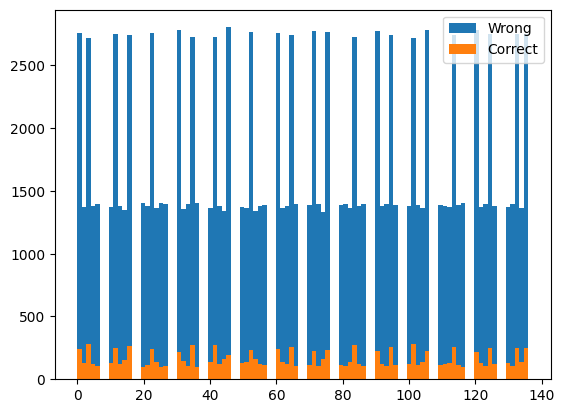

In [44]:
errors = []
corrects = []
for round_idx, rfs in enumerate(random_forests):
    for block_idx, rfc in enumerate(rfs):
        keyround_index = round_idx * BLOCK_WIDTH_B4 + block_idx
        classifications_log_proba = rfc.predict(traces_test_reduced[round_idx, block_idx])
        for i, seed in enumerate(seeds_test):
            indices, whitening = chacha_random_b4(seed)
            key_index = indices[keyround_index]
            if (classifications_log_proba[i] - whitening[keyround_index]) % 16 != real_keys[0][key_index]:
                errors.append((round_idx, block_idx))
            else:
                corrects.append((round_idx, block_idx))
plt.hist([10 * r + b for r, b in errors], bins=100, label="Wrong")
plt.hist([10 * r + b for r, b in corrects], bins=100, label="Correct")
plt.legend()
plt.show()